In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dir = '/kaggle/input/catdata/catData'
print(os.listdir(dir))

['cats']


In [3]:
print(os.listdir(dir+'/cats')[:20])

['7981.jpg', '623.jpg', '7966.jpg', '9960.jpg', '9131.jpg', '9620.jpg', '9062.jpg', '8953.jpg', '764.jpg', '7894.jpg', '8930.jpg', '8983.jpg', '9697.jpg', '771.jpg', '8352.jpg', '208.jpg', '8104.jpg', '9645.jpg', '9579.jpg', '820.jpg']


In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [5]:

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

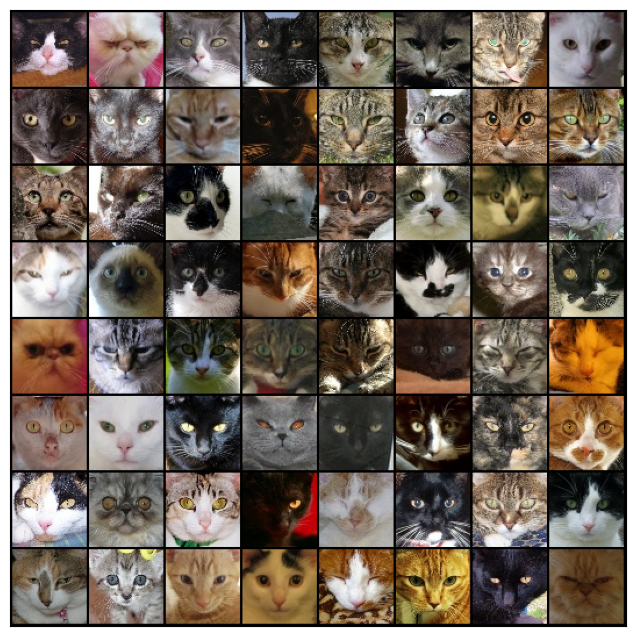

In [7]:
show_batch(train_dl)

In [8]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')


In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device=is_cuda_available()
train_dl = DeviceDataLoader(train_dl, device)

CUDA available. Training on GPU!


In [12]:

discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),


    nn.Flatten(),
    nn.Sigmoid())

In [13]:
discriminator = to_device(discriminator, device)

In [14]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


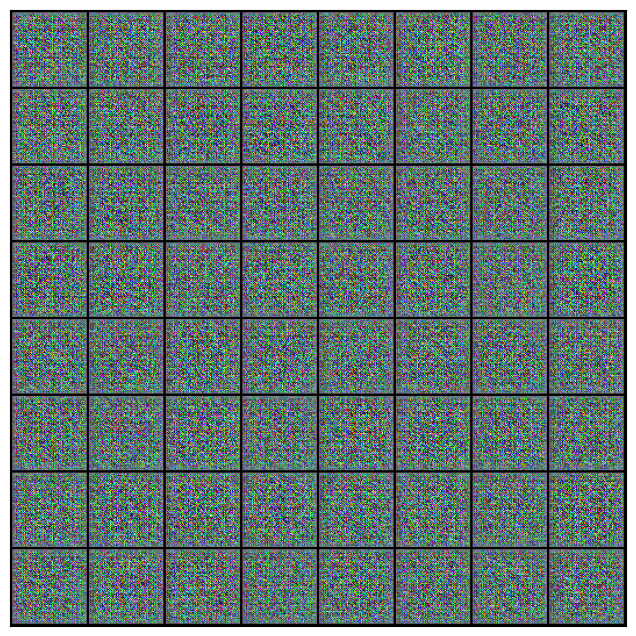

In [15]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [16]:
generator = to_device(generator, device)

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [18]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()


In [19]:

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [20]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [21]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


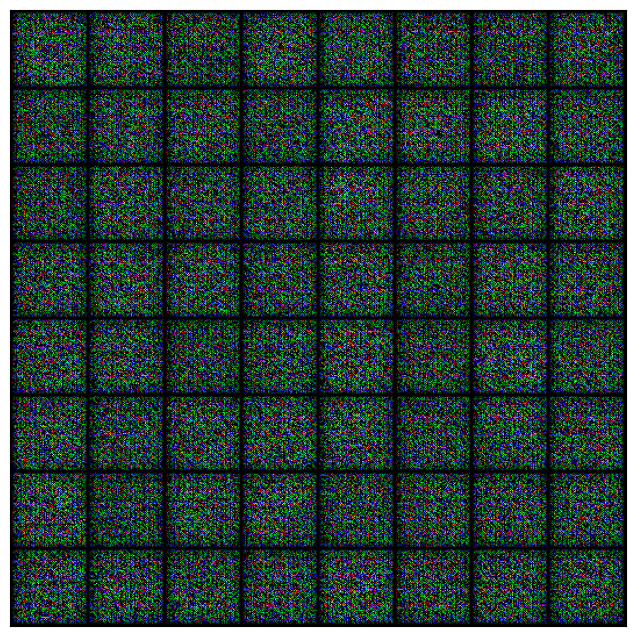

In [22]:
save_samples(0, fixed_latent)

In [23]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [24]:
lr = 0.0003
epochs = 60

In [25]:
history=fit(epochs,lr)

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 7.4166, loss_d: 3.8357, real_score: 0.9761, fake_score: 0.9406
Saving generated-images-0001.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 2.0842, loss_d: 0.8999, real_score: 0.5291, fake_score: 0.0739
Saving generated-images-0002.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 3.7640, loss_d: 0.8595, real_score: 0.7755, fake_score: 0.3835
Saving generated-images-0003.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 4.3500, loss_d: 0.8065, real_score: 0.5510, fake_score: 0.0200
Saving generated-images-0004.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 3.2098, loss_d: 0.1997, real_score: 0.8759, fake_score: 0.0594
Saving generated-images-0005.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 4.0781, loss_d: 0.3871, real_score: 0.8139, fake_score: 0.1434
Saving generated-images-0006.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 4.0972, loss_d: 0.4035, real_score: 0.7781, fake_score: 0.0832
Saving generated-images-0007.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 4.2908, loss_d: 0.3034, real_score: 0.9548, fake_score: 0.2163
Saving generated-images-0008.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 3.5690, loss_d: 0.6503, real_score: 0.5895, fake_score: 0.0255
Saving generated-images-0009.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 1.6593, loss_d: 0.9075, real_score: 0.5518, fake_score: 0.1498
Saving generated-images-0010.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 5.8461, loss_d: 2.7592, real_score: 0.1126, fake_score: 0.0006
Saving generated-images-0011.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 3.6277, loss_d: 0.2823, real_score: 0.8241, fake_score: 0.0596
Saving generated-images-0012.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 3.5629, loss_d: 0.1279, real_score: 0.9462, fake_score: 0.0673
Saving generated-images-0013.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 5.6700, loss_d: 0.5548, real_score: 0.9444, fake_score: 0.3726
Saving generated-images-0014.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 5.4509, loss_d: 0.3488, real_score: 0.9814, fake_score: 0.2605
Saving generated-images-0015.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 3.1178, loss_d: 0.1496, real_score: 0.9579, fake_score: 0.0949
Saving generated-images-0016.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 7.6752, loss_d: 0.6162, real_score: 0.9839, fake_score: 0.3985
Saving generated-images-0017.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 4.2188, loss_d: 0.2574, real_score: 0.8935, fake_score: 0.1114
Saving generated-images-0018.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 7.5843, loss_d: 0.7323, real_score: 0.9582, fake_score: 0.4440
Saving generated-images-0019.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 5.4468, loss_d: 0.1014, real_score: 0.9183, fake_score: 0.0101
Saving generated-images-0020.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 5.6605, loss_d: 0.1185, real_score: 0.9858, fake_score: 0.0945
Saving generated-images-0021.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 5.1792, loss_d: 0.1762, real_score: 0.9750, fake_score: 0.1309
Saving generated-images-0022.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 4.7533, loss_d: 0.2207, real_score: 0.8594, fake_score: 0.0550
Saving generated-images-0023.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 4.1518, loss_d: 0.0724, real_score: 0.9494, fake_score: 0.0163
Saving generated-images-0024.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 7.8294, loss_d: 0.8534, real_score: 0.5912, fake_score: 0.0019
Saving generated-images-0025.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 5.1068, loss_d: 0.1096, real_score: 0.9969, fake_score: 0.0937
Saving generated-images-0026.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 5.2604, loss_d: 0.1647, real_score: 0.9085, fake_score: 0.0544
Saving generated-images-0027.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 7.5840, loss_d: 0.0230, real_score: 0.9945, fake_score: 0.0170
Saving generated-images-0028.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 3.5407, loss_d: 0.1491, real_score: 0.9140, fake_score: 0.0322
Saving generated-images-0029.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 4.9754, loss_d: 0.1948, real_score: 0.9363, fake_score: 0.0661
Saving generated-images-0030.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 5.5807, loss_d: 0.0213, real_score: 0.9914, fake_score: 0.0124
Saving generated-images-0031.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 14.2640, loss_d: 1.4237, real_score: 0.9920, fake_score: 0.5847
Saving generated-images-0032.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 9.7542, loss_d: 1.4777, real_score: 0.3358, fake_score: 0.0001
Saving generated-images-0033.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 5.6353, loss_d: 0.1501, real_score: 0.9933, fake_score: 0.1219
Saving generated-images-0034.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 8.3031, loss_d: 0.2778, real_score: 0.9891, fake_score: 0.1892
Saving generated-images-0035.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 5.6465, loss_d: 0.0305, real_score: 0.9949, fake_score: 0.0247
Saving generated-images-0036.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 12.0532, loss_d: 0.8095, real_score: 0.9827, fake_score: 0.4801
Saving generated-images-0037.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 4.7922, loss_d: 0.0570, real_score: 0.9678, fake_score: 0.0229
Saving generated-images-0038.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 7.6095, loss_d: 0.8543, real_score: 0.5177, fake_score: 0.0001
Saving generated-images-0039.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 4.3800, loss_d: 0.0669, real_score: 0.9803, fake_score: 0.0441
Saving generated-images-0040.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 6.8816, loss_d: 0.0938, real_score: 0.9314, fake_score: 0.0148
Saving generated-images-0041.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 6.1225, loss_d: 0.0524, real_score: 0.9881, fake_score: 0.0357
Saving generated-images-0042.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 2.8288, loss_d: 0.2704, real_score: 0.8212, fake_score: 0.0224
Saving generated-images-0043.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 7.5400, loss_d: 0.1579, real_score: 0.9937, fake_score: 0.1116
Saving generated-images-0044.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 4.7008, loss_d: 0.1169, real_score: 0.9618, fake_score: 0.0704
Saving generated-images-0045.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 6.6592, loss_d: 0.0227, real_score: 0.9796, fake_score: 0.0016
Saving generated-images-0046.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 6.5123, loss_d: 0.0133, real_score: 0.9956, fake_score: 0.0082
Saving generated-images-0047.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 12.9008, loss_d: 0.0286, real_score: 0.9723, fake_score: 0.0000
Saving generated-images-0048.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 8.0402, loss_d: 0.1935, real_score: 0.9999, fake_score: 0.1453
Saving generated-images-0049.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 6.2159, loss_d: 0.0841, real_score: 0.9918, fake_score: 0.0614
Saving generated-images-0050.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 6.2311, loss_d: 0.5119, real_score: 0.7031, fake_score: 0.0014
Saving generated-images-0051.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 6.9517, loss_d: 0.0202, real_score: 0.9920, fake_score: 0.0118
Saving generated-images-0052.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 9.4489, loss_d: 0.0715, real_score: 0.9338, fake_score: 0.0002
Saving generated-images-0053.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 6.0451, loss_d: 0.1100, real_score: 0.9214, fake_score: 0.0143
Saving generated-images-0054.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 8.4853, loss_d: 0.1910, real_score: 0.9959, fake_score: 0.1516
Saving generated-images-0055.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 3.5644, loss_d: 0.1006, real_score: 0.9985, fake_score: 0.0866
Saving generated-images-0056.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 9.4116, loss_d: 0.0110, real_score: 0.9901, fake_score: 0.0009
Saving generated-images-0057.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 9.6942, loss_d: 0.5205, real_score: 0.6714, fake_score: 0.0002
Saving generated-images-0058.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 11.4717, loss_d: 0.5701, real_score: 0.9763, fake_score: 0.3124
Saving generated-images-0059.png


  0%|          | 0/149 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 5.1640, loss_d: 0.0169, real_score: 0.9961, fake_score: 0.0123
Saving generated-images-0060.png


In [26]:
losses_g, losses_d, real_scores, fake_scores = history

In [27]:
from IPython.display import Image

One Fake generated image:

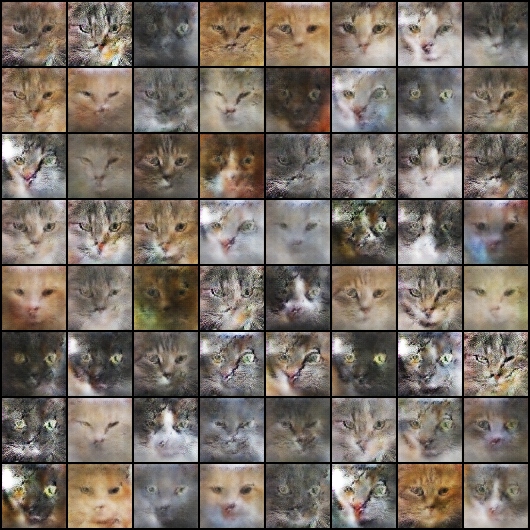

In [28]:
Image('./generated/generated-images-0033.png')

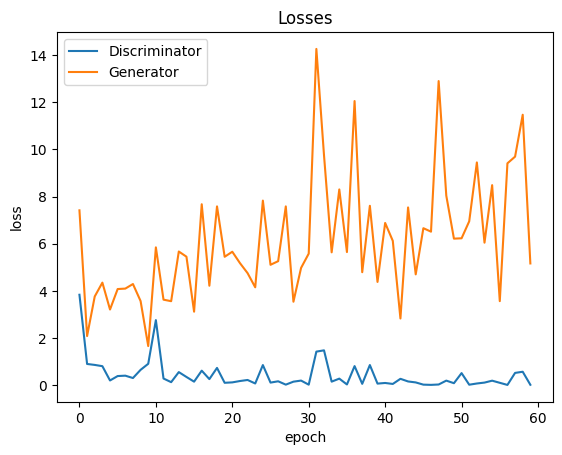

In [30]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

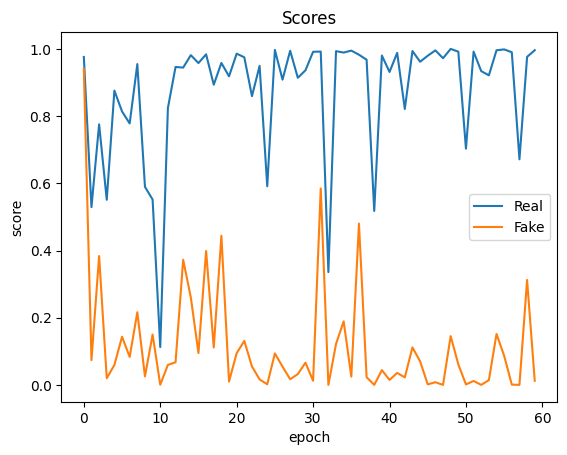

In [31]:

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Saving generated-images-0000.png


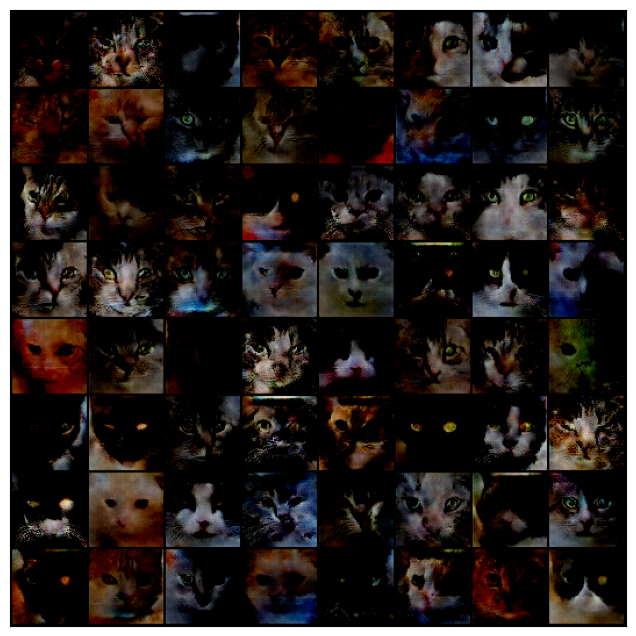

In [32]:
save_samples(0, fixed_latent)